# Imports

In [1]:
import torch
torch.cuda.empty_cache()

from _occupancy_forecasting import ResultsAnalyis

from _dfguru import DataFrameGuru as DFG
import pandas as pd
dfguru = DFG()

## Load results

In [2]:
path_to_data = "data/occupancy_forecasting"

paths_to_checkpoints = [
    "/home/berni/transfer_from_server/wrap_up_combs_1",
    "/home/berni/transfer_from_server/wrap_up_combs_2",
    "/home/berni/transfer_from_server/wrap_up_combs_3"
]
paths_to_results = [
    "results_wrapup_normal_combs_1.txt",
    "results_wrapup_normal_combs_2.txt",
    "results_wrapup_normal_combs_3.txt"
]

analyzer = ResultsAnalyis(
    path_to_data=path_to_data,
    dfguru=dfguru
)

#{
#    "loss_type": "MAE",
#    #"dataset": "test"
#    #"frequency": "15min",
#    #"lr": "0.001",
#    #"batch_size": "32",
#    # "with_examweek": "False",
#    #"course_encoding_dim": "3",
#    #"room_ids": "[0]",
#    #"num_layers": "3",
#    #"hidden_size": "[32, 32]",
#    #"y_horizon": "36",
#    #"dataset": "test"
#}

#parse_results = analyzer.data_preparation(paths_to_results, paths_to_checkpoints)
#pivot_results = analyzer.filter_clean_pivot(parse_results, {"loss_type": "MAE"})

In [3]:
#analyzer.save_dataframe(pivot_results, "" ,"pivot_results")

In [4]:
pivot_results = analyzer.load_dataframe("", "pivot_results")
pivot_results.value_counts("run_id")

run_id
0    2048
1    2048
2    2048
3    2048
4    2048
Name: count, dtype: int64

In [5]:
pivot_results = pivot_results[["features","run_id","test_loss"]]

## Grouping and Basic Scatter Plots

In [6]:
df_not_grouped = pivot_results.reset_index()
df_feature_grouped = analyzer.group_by_features(pivot_results, "test_loss")

In [7]:
# same result with df_not_grouped except for some std values -> avg of avg
#df_subfeature_grouped = analyzer.group_by_subfeatures(df_feature_grouped, "mean_loss").sort_values("mean_loss").reset_index(drop=True)

In [8]:
# same result with df_not_grouped except for some std values -> avg of avg
df_fundamental_grouped = analyzer.group_by_fundamental_features(df_feature_grouped, "mean_loss")

In [9]:
df_component_grouped = analyzer.group_by_component_features(df_feature_grouped, "mean_loss")

In [10]:
analyzer.scatter_plot_feature_group(df_feature_grouped)

### Code to print group by fundamental features tables

In [11]:
df_fundamental_grouped = analyzer.group_by_fundamental_features(df_feature_grouped, "mean_loss")
df_fundamental_grouped.set_index("features", inplace=True)

df_fundamental_grouped.sort_values("mean_loss")

,mean_loss,std_loss,count
features,,,
coursenumber,0.016635,0.000684,1024
studyarea,0.016653,0.000559,1024
registered,0.016774,0.000774,1024
type,0.016785,0.000791,1024
lecture,0.016828,0.000774,1024
tutorium_test_cancelled,0.016857,0.000995,1024
hod,0.016884,0.000887,1024
dow,0.016902,0.000854,1024
occrate,0.016935,0.000920,2048


In [15]:
K = 25
df_in = analyzer.top_k_rows(df_feature_grouped, "mean_loss", K, True)
df_fundamental_grouped = analyzer.group_by_fundamental_features(df_in, "mean_loss")
df_fundamental_grouped.set_index("features", inplace=True)

df_fundamental_grouped.sort_values("mean_loss")

,mean_loss,std_loss,count
features,,,
avgocc,0.014952,0.000184,14
hod,0.014984,0.000169,13
registered,0.014990,0.000169,16
type,0.014991,0.000169,21
coursenumber,0.014998,0.000161,24
occrate,0.015004,0.000161,25
tutorium_test_cancelled,0.015004,0.000161,25
lecture,0.015027,0.000146,12
studyarea,0.015090,0.000085,6


In [141]:
import plotly.graph_objects as go


def process_and_plot_plotly(df_feature_grouped, K_values, sort_column, ascending=True):
    """
    Process the DataFrame for various K values and create an interactive line plot using Plotly,
    with feature combinations as individual lines.

    Parameters:
    df_feature_grouped: DataFrame with feature combinations and metrics.
    K_values: List of K values to filter the top rows.
    sort_column: The column to sort by (e.g., "mean_loss").
    ascending: Sort order for the sort_column (default is True).

    Returns:
    A DataFrame with fundamental features, K values, and metrics.
    """
    
    # Initialize a dictionary to store results
    results = {}

    for K in K_values:
        # Filter top K rows
        df_in = analyzer.top_k_rows(df_feature_grouped, sort_column, K, ascending)
        
        # Group by fundamental features
        df_fundamental_grouped = analyzer.group_by_fundamental_features(df_in, sort_column)

        # Store results in the dictionary
        results[K] = df_fundamental_grouped.set_index("features")[sort_column]
        

    # Combine all results into a single DataFrame
    results_df = pd.DataFrame(results).reset_index()

    # Copy the results DataFrame for further processing
    df = results_df.copy()

    # Create the Plotly figure
    fig = go.Figure()
        
    # Add a trace for each feature combination
    for _, row in df.iterrows():
        #order_dict = dict()
        order = []
        for k in K_values:
            # Calculate ranks for the specific K value
            sorted_df = df[[k]].sort_values(by=k, ascending=ascending).reset_index()
            #order_dict[k] = int(sorted_df[sorted_df["index"] == row.name].index[0]) + 1
            order.append(int(sorted_df[sorted_df["index"] == row.name].index[0]) + 1)

        # Add trace with hover info including rank
        fig.add_trace(go.Scatter(
            x=K_values,
            y=row[1:],
            mode='lines+markers',
            name=row['features'],
            customdata=order,
            hovertemplate=(
                f"<b>Feature:</b> {row['features']}<br>"+
                "<b>K:</b> %{x}<br>"+
                "<b>Rank:</b> %{customdata}<br>"+
                f"<b>{sort_column}:</b>" + " %{y:.6f}<extra></extra>"
            ),
        ))


    # Update layout for better visualization
    fig.update_layout(
        title=f"{sort_column} vs K (Interactive)",
        xaxis_title="K (Top Rows Considered)",
        yaxis_title=sort_column,
        legend_title="Features",
        template="plotly_white",
        margin=dict(l=50, r=50, t=50, b=50),
        height=800,  # Increased plot height
    )

    # Show the interactive plot
    fig.show()

    return df

# Example Usage
K_values = [10, 25, 50, 100]  # Define the K values you want to vary
res_df = process_and_plot_plotly(df_feature_grouped, K_values, "mean_loss")


### Code to print group by feature tables

In [142]:

# group by feature results
import pandas as pd
pd.set_option('display.max_colwidth', 100)

df_print = df_feature_grouped.copy(deep = True)
df_print["features"] = df_print["features"].apply(lambda x: x.split("_"))
# rename features to feature_combination
df_print.rename(columns={"features": "feature_combination"}, inplace=True)


df_print.sort_values("std_loss", ascending=True).head(5)

,feature_combination,mean_loss,std_loss
110,"[occrate, coursenumber, type, registered, studyarea]",0.015610,0.000058
68,"[occrate, coursenumber, hod, tutorium, test, cancelled, registered, studyarea]",0.015444,0.000085
615,"[occrate, avgocc, coursenumber, weather, tutorium, test, cancelled, type, registered]",0.016494,0.000085
447,"[occrate, type, lecture]",0.016299,0.000093
47,"[occrate, avgocc, coursenumber, dow, hod, tutorium, test, cancelled, registered]",0.015354,0.000100


In [ ]:
# in df_not_grouped locate the feature with the highest std

#1. get the feature with the highest std in df_grouped_by_features
#2. get the all runs of said feature in df_not_grouped
high_std_feature = df_feature_grouped.sort_values("std_loss", ascending=True)[:1]["features"].values[0]

df_high_std_feature = df_not_grouped[df_not_grouped["features"] == high_std_feature]
df_high_std_feature.sort_values("test_loss", ascending=True)

,index,features,run_id,test_loss
7037,7037,occrate_coursenumber_type_registered_studyarea,2,0.015533
7035,7035,occrate_coursenumber_type_registered_studyarea,0,0.015571
7038,7038,occrate_coursenumber_type_registered_studyarea,3,0.015614
7036,7036,occrate_coursenumber_type_registered_studyarea,1,0.015657
7039,7039,occrate_coursenumber_type_registered_studyarea,4,0.015673


In [7]:
# not really applicable for that many combinations

#import seaborn as sns

## Convert feature analysis to a DataFrame if not already
#heatmap_data = df_features_and_combs[['mean_validation_mae', 'mean_test_mae']]
#sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm")
#plt.title("Performance of Individual Features")
#plt.show()


In [8]:
#from pandas.plotting import parallel_coordinates

## not really applicable for that many combinations

#top_combinations = df_grouped.nsmallest(100, 'mean_test_mae')  # Top 100 combinations
#parallel_data = top_combinations.melt(id_vars='features', value_vars=['mean_validation_mae', 'std_validation_mae', 'mean_test_mae', 'std_test_mae'])

## Pivot the melted data back to wide format
#wide_data = parallel_data.pivot(index='features', columns='variable', values='value').reset_index()

## Plot parallel coordinates
#parallel_coordinates(wide_data, 'features', color=['blue', 'green', 'red', 'purple'])
#plt.title("Parallel Coordinates Plot for Feature Combinations")
#plt.show()

In [9]:
# not really applicable for that many combinations

#df_features_and_combs[['mean_validation_mae', 'mean_test_mae']].plot.bar(
#    yerr=df_features_and_combs[['std_validation_mae', 'std_test_mae']].values.T,
#    figsize=(10, 6),
#    capsize=4,
#    title="Mean and Std of MAE for Individual Features"
#)
#plt.show()


In [10]:
## Split the strings into lists of fundamental features
#fundamental_features = ["occrate", "exam", "tutorium_test_cancelled", "registered", "type", 
#                    "studyarea", "coursenumber", "dow", "hod", "weather", "avgocc"]
## Function to split strings into fundamental features
#def extract_fundamental_features(feature_string, fundamental_features):
#    # Split the string by underscore and filter for fundamental features
#    return [f for f in fundamental_features if f in feature_string]
#df["fundamental_features"] = df["features"].apply(lambda x: extract_fundamental_features(x, fundamental_features))
#print(df['fundamental_features'])

In [11]:
df_plot = df_feature_grouped.copy(deep=True)

# get benchmark row for comparison
benchmark = df_plot[df_plot["features"] == "occrate"]

df_plot["mean_test_mae"] = benchmark["mean_test_mae"].values[0] - df_plot["mean_test_mae"]

In [12]:
analyzer.scatter_plot_feature_group(df_plot)

## Correlation

In [13]:
# no benchmark possible -> correlation coef is invariant to scale and location changes

#target_column = "test_loss"
target_column = "mean_test_mae"
dataframe = df_feature_grouped
correlations = analyzer.correlate_features_with_loss(dataframe, target_column)
print(correlations.sort_values(ascending=False))

exam                       0.364959
weather                    0.296115
avgocc                     0.004425
dow                       -0.035987
hod                       -0.055513
tutorium_test_cancelled   -0.084838
type                      -0.162839
registered                -0.174820
studyarea                 -0.306186
coursenumber              -0.326157
occrate                         NaN
dtype: float64


## Marginal Contribution

In [14]:
def calc_marginal_contribution(dataframe, feature, target):
    with_feature = dataframe[dataframe['features'].str.contains(feature)]
    without_feature = dataframe[~dataframe['features'].str.contains(feature)]
    return with_feature[target].mean() - without_feature[target].mean()
    
    
df = df_feature_grouped
target = "mean_test_mae" 
#for feature in all_features:
for feature in analyzer.fundamental_features:
    impact = calc_marginal_contribution(df, feature, "mean_test_mae")
    print(f"Impact of {feature}: {impact:.6f}")

Impact of occrate: nan
Impact of exam: 0.000672
Impact of tutorium_test_cancelled: -0.000156
Impact of registered: -0.000322
Impact of type: -0.000300
Impact of studyarea: -0.000564
Impact of coursenumber: -0.000600
Impact of dow: -0.000066
Impact of hod: -0.000102
Impact of weather: 0.000545
Impact of avgocc: 0.000008


In [38]:
# not so useful --> gets washed out by the number of features
# averaging over so many features is not so important
df = df_feature_grouped
target = "mean_test_mae"

for feature in analyzer.fundamental_features:
    benchmark_improvement = analyzer.calc_benchmark_improvement(df, feature, target).sort_values(feature)
    print(f"{feature}: {benchmark_improvement["improvement"].values}")

occrate: [0.00439245]
exam: [0.00472829 0.00405661]
tutorium_test_cancelled: [0.00431438 0.00447052]
registered: [0.00423158 0.00455332]
type: [0.00424261 0.0045423 ]
studyarea: [0.0041107 0.0046742]
coursenumber: [0.00409232 0.00469258]
dow: [0.00435934 0.00442557]
hod: [0.00434137 0.00444353]
weather: [0.00466494 0.00411996]
avgocc: [0.00439652 0.00438838]


In [33]:
dataframe = df_feature_grouped
target = "mean_test_mae"
feature = "tutorium_test_cancelled"
feature_inclusion, impact = analyzer.calc_feature_inclusion(dataframe, feature, target)

,tutorium_test_cancelled,mean,std
0,False,0.017013,0.000833
1,True,0.016857,0.000995


## Linear Regression and Model agnostic 

In [59]:
dataframe

,features,mean_validation_mae,std_validation_mae,mean_test_mae,std_test_mae,exam,tutorium_test_cancelled,occrate,registered,type,studyarea,coursenumber,dow,hod,weather,avgocc
343,occrate_avgocc_coursenumber_hod_tutorium_test_...,0.008524,0.000284,0.014703,0.000416,False,True,True,True,True,False,True,False,True,False,True
373,occrate_avgocc_coursenumber_tutorium_test_canc...,0.008143,0.000112,0.014737,0.000294,False,True,True,True,True,False,True,False,False,False,True
370,occrate_avgocc_coursenumber_tutorium_test_canc...,0.008034,0.000223,0.014757,0.000180,False,True,True,False,True,False,True,False,False,False,True
23,occrate_avgocc_coursenumber_dow_hod_tutorium_t...,0.008305,0.000300,0.014768,0.000221,False,True,True,True,True,False,True,True,True,False,True
342,occrate_avgocc_coursenumber_hod_tutorium_test_...,0.008658,0.000327,0.014773,0.000337,False,True,True,True,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,occrate_dow,0.014428,0.000293,0.021907,0.000541,False,False,True,False,False,False,False,True,False,False,False
1602,occrate_exam_dow,0.014153,0.000315,0.022002,0.001008,True,False,True,False,False,False,False,True,False,False,False
1577,occrate_dow_tutorium_test_cancelled,0.014771,0.000536,0.022033,0.000623,False,True,True,False,False,False,False,True,False,False,False
2024,occrate_weather_tutorium_test_cancelled,0.015426,0.000359,0.022208,0.000491,False,True,True,False,False,False,False,False,False,True,False


In [88]:
dataframe = df_feature_grouped
target = "mean_test_mae"
#target = "std_test_mae"

y_true = dataframe[target]

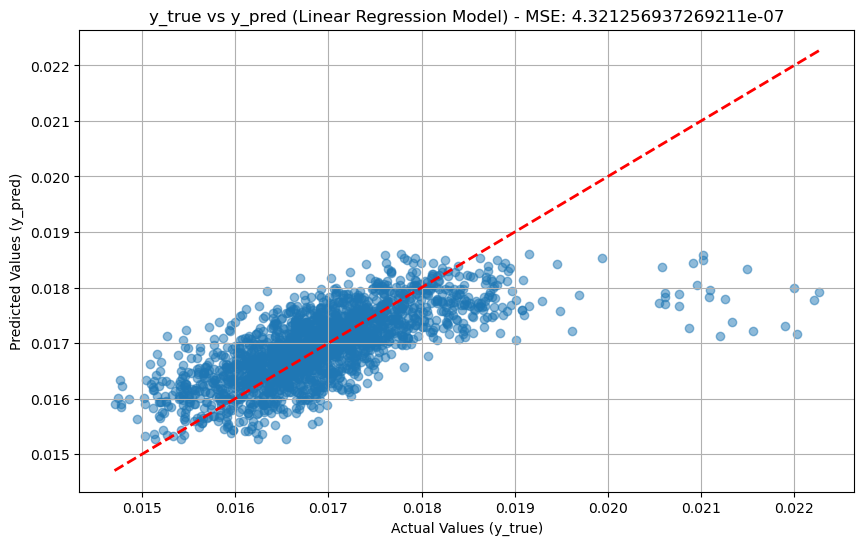

In [124]:
reg_results, model, y_pred = analyzer.calc_linear_regression(dataframe, target, intercept=False)
analyzer.scatter_plot_target_prediction("Linear Regression Model", y_true, y_pred)

In [125]:
import shap
X = analyzer.get_binary_features(dataframe)
X_shap = shap.utils.sample(X, len(X)//5)

In [126]:
# check reference
explainer = shap.LinearExplainer(model, X_shap)
shap_values = explainer(X)

In [137]:
#explainer = shap.Explainer(model.predict, X_shap)
#shap_values = explainer(X)
reg_results.sort_values()

coursenumber              -0.000600
studyarea                 -0.000564
registered                -0.000322
type                      -0.000300
tutorium_test_cancelled   -0.000156
hod                       -0.000102
dow                       -0.000066
avgocc                     0.000008
weather                    0.000545
exam                       0.000672
occrate                    0.017378
dtype: float64

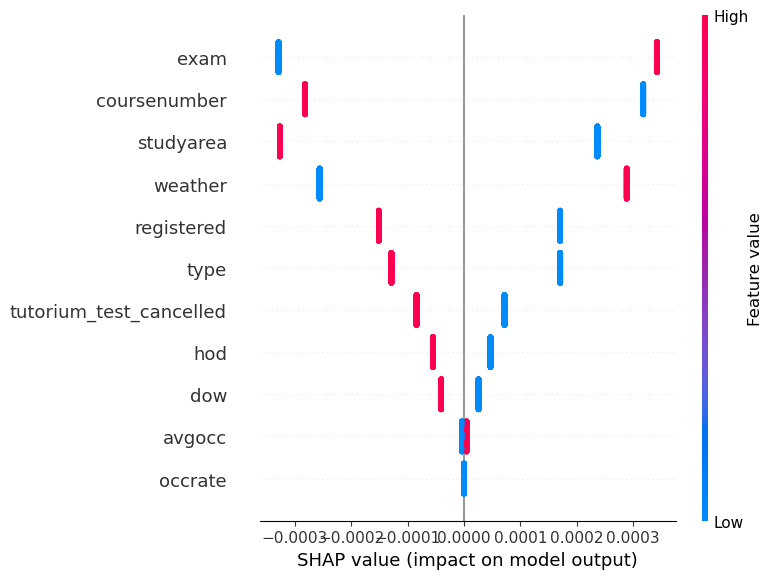

In [134]:
shap.summary_plot(shap_values, X)

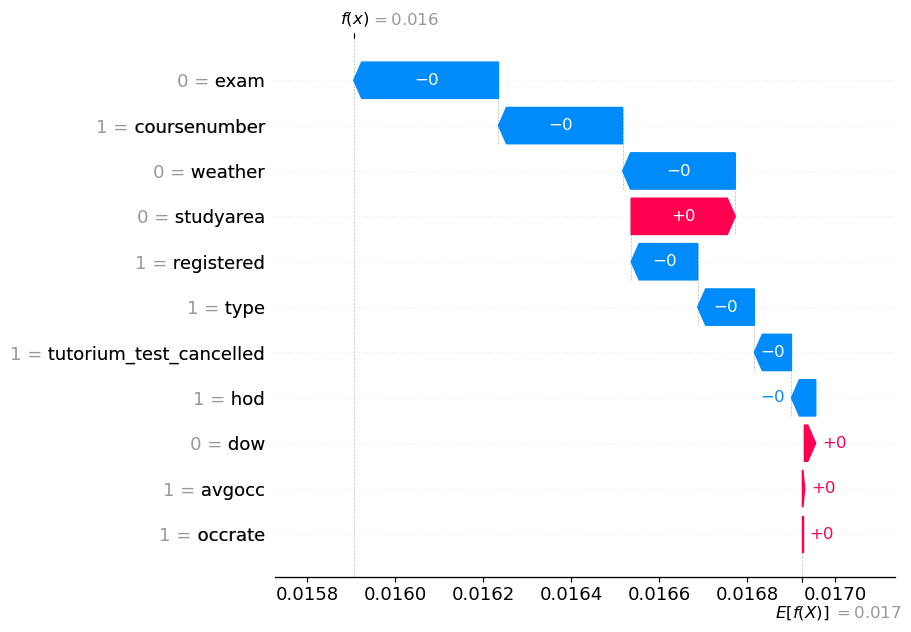

In [106]:
# explains one sample --> sadly precision is a little bit too little
shap.plots.waterfall(shap_values[0], max_display=14)

In [ ]:

explainer = shap.Explainer(model.predict, X_shap)
shap_values = explainer(X)

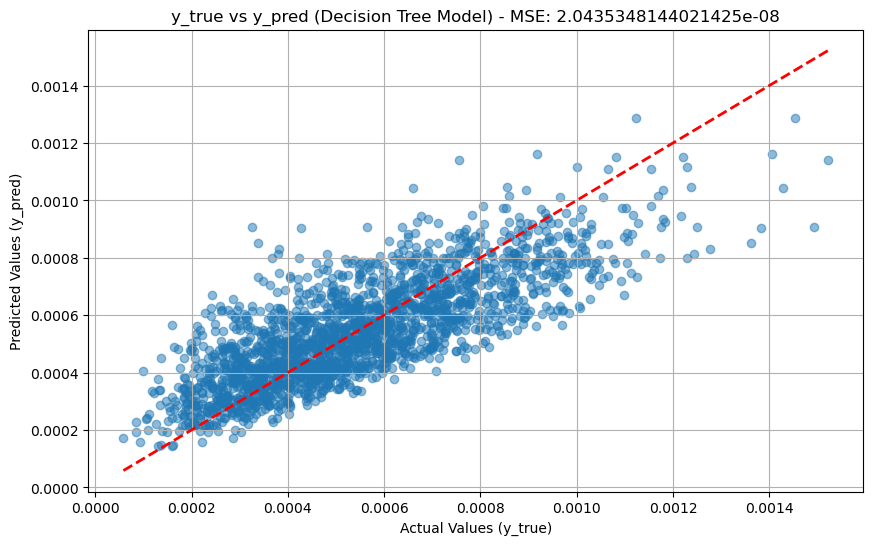

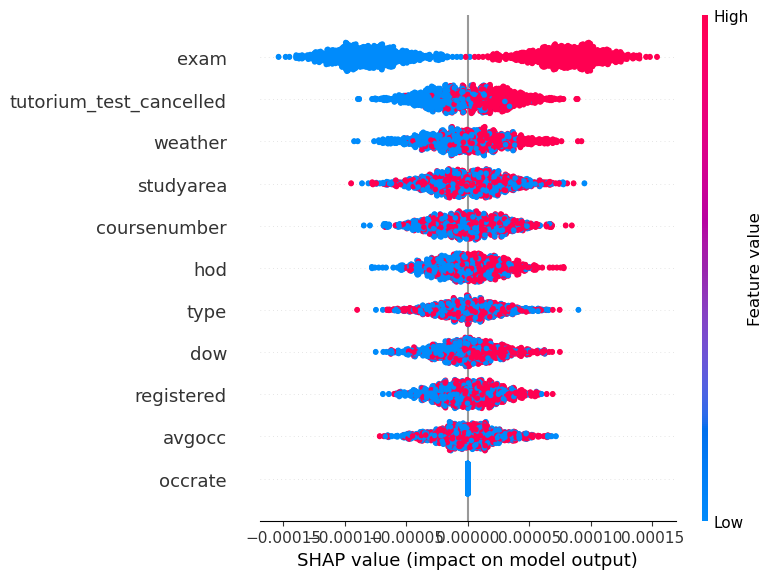

In [74]:
import shap


model, y_pred = analyzer.calc_decision_tree(dataframe, target)
analyzer.scatter_plot_target_prediction("Decision Tree Model", y_true, y_pred)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
shap_set = analyzer.get_binary_features(dataframe)
shap_values = explainer(shap_set)

# Summary plot for SHAP values
shap.summary_plot(shap_values, shap_set)

## Not really consider

Explain model hard to interpret with model hard to interpret 
--> not nice

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the neural network
class MLPRegressorPyTorch(nn.Module):
    def __init__(self, input_size, hidden_1, hidden_2, output_size):
        super(MLPRegressorPyTorch, self).__init__()
        
        self.hidden_1 = nn.Linear(input_size, hidden_1)
        
        #self.hidden_2 = nn.Linear(hidden_1, hidden_2)
        self.relu = nn.ReLU()
        
        self.output = nn.Linear(hidden_1, output_size)

    def forward(self, x):
        x = self.hidden_1(x)
        x = self.relu(x)
        #x = self.hidden_2(x)
        #x = self.relu(x)
        x = self.output(x)
        return x

In [85]:

target = "mean_test_mae"
# Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

X = analyzer.get_binary_features(dataframe)
y = dataframe[target]

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
output_size = 1

model = MLPRegressorPyTorch(input_size, 100, 1, output_size)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        # Forward pass
        batch_X = batch_X.to(device)
        
        predictions = model(batch_X)
        predictions = predictions.to("cpu")
        
        loss = criterion(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Optional: print progress every 50 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
model.to("cpu")
with torch.no_grad():
    y_pred_tensor = model(X_tensor)
    y_pred_mlp = y_pred_tensor.numpy()


mse_mlp = criterion(y_tensor, y_pred_tensor)
print("MLP - Improved MSE:", mse_mlp)


Epoch 10/200, Loss: 9.696935165948162e-08
Epoch 20/200, Loss: 4.612630721823052e-09
Epoch 30/200, Loss: 1.1002003752480505e-08
Epoch 40/200, Loss: 7.96169974393024e-09
Epoch 50/200, Loss: 7.973555682383449e-08
Epoch 60/200, Loss: 3.0937377104578445e-09
Epoch 70/200, Loss: 3.3893432060949635e-08
Epoch 80/200, Loss: 3.427927808274944e-08
Epoch 90/200, Loss: 1.8672043466949617e-08
Epoch 100/200, Loss: 2.3176853858331015e-07
Epoch 110/200, Loss: 1.7941084706762922e-07
Epoch 120/200, Loss: 5.6940688608619894e-08


KeyboardInterrupt: 

In [86]:
# Evaluate the model
model.eval()
model.to("cpu")
with torch.no_grad():
    y_pred_tensor = model(X_tensor)
    y_pred_mlp = y_pred_tensor.numpy()


mse_mlp = criterion(y_tensor, y_pred_tensor)
print("MLP - Improved MSE:", mse_mlp)


MLP - Improved MSE: tensor(6.8843e-08)


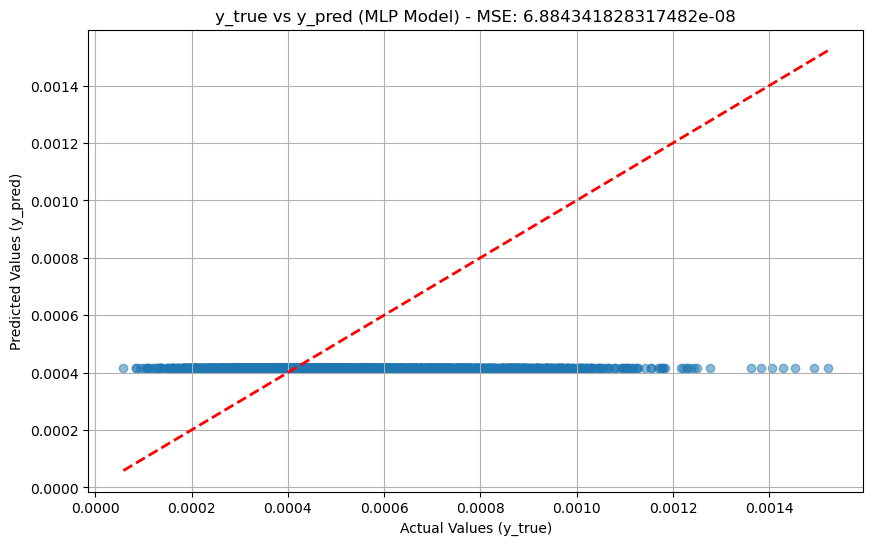

In [87]:
analyzer.scatter_plot_target_prediction("MLP Model", y_true, y_pred_mlp)

### Gridsearch

MLP - Best Parameters: {'alpha': 0, 'batch_size': 8, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.0001, 'max_iter': 3000}
MLP - Improved MSE: 0.0003346691718070262


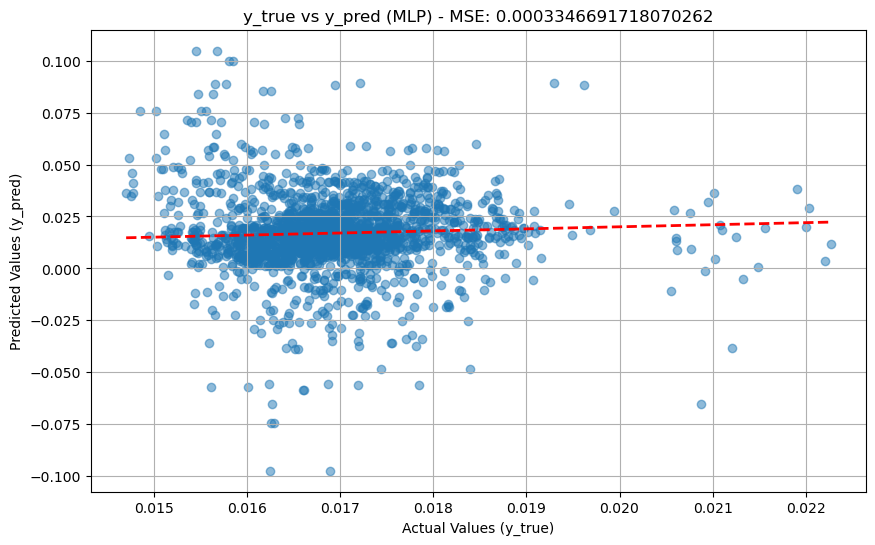

In [ ]:
# Small MLP - Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid_mlp = {
    "hidden_layer_sizes": [(10)],
    "learning_rate_init": [0.0001],
    "batch_size": [8],
    "alpha": [0],
    "max_iter": [3000]
}

grid_search_mlp = GridSearchCV(MLPRegressor(activation="relu", solver="adam", random_state=42), param_grid_mlp, cv=5, scoring="neg_mean_squared_error")
grid_search_mlp.fit(X, y)

best_mlp = grid_search_mlp.best_estimator_
print("MLP - Best Parameters:", grid_search_mlp.best_params_)
y_pred_mlp = best_mlp.predict(X)
mse_mlp = mean_squared_error(y, y_pred_mlp)
print("MLP - Improved MSE:", mse_mlp)

analyzer.scatter_plot_target_prediction("MLP", y, y_pred_mlp)

### Explanation of Correlation

Why `occrate` is NaN

====================

- The `occrate` column in `binary_features` is constant (all 1s):

  occrate

  1

  1

  1

  1



- A constant feature has zero variance (σ_X = 0).

- In Pearson's correlation formula:

  r = Cov(X, Y) / (σ_X ⋅ σ_Y)

  The denominator (σ_X) becomes zero, and the correlation cannot be computed, resulting in `NaN`.



Calculation for `avgocc`

=========================

We calculate the correlation for `avgocc` as an example.



Values:

-------

- X = [0, 1, 1, 0] (from `binary_features['avgocc']`)

- Y = [0.012485, 0.012285, 0.013611, 0.014393] (from `target_metrics`)



Step 1: Compute Means

---------------------

X̄ = (0 + 1 + 1 + 0) / 4 = 0.5

Ȳ = (0.012485 + 0.012285 + 0.013611 + 0.014393) / 4 = 0.013194



Step 2: Compute Deviations

--------------------------

X_i - X̄ = [-0.5, 0.5, 0.5, -0.5]

Y_i - Ȳ = [0.012485 - 0.013194, 0.012285 - 0.013194, 0.013611 - 0.013194, 0.014393 - 0.013194]

        = [-0.000709, -0.000909, 0.000417, 0.001199]



Step 3: Compute Covariance

--------------------------

Cov(X, Y) = Σ (X_i - X̄)(Y_i - Ȳ)

          = (-0.5)(-0.000709) + (0.5)(-0.000909) + (0.5)(0.000417) + (-0.5)(0.001199)

          = 0.000354 - 0.000455 + 0.000208 - 0.000599 = -0.000492



Step 4: Compute Variances

-------------------------

σ_X² = Σ (X_i - X̄)² = (-0.5)² + (0.5)² + (0.5)² + (-0.5)² = 1.0

σ_Y² = Σ (Y_i - Ȳ)²

      = (-0.000709)² + (-0.000909)² + (0.000417)² + (0.001199)²

      = 0.000000503 + 0.000000826 + 0.000000174 + 0.000001438 = 0.000002941



σ_X = √1.0 = 1.0

σ_Y = √0.000002941 = 0.001715



Step 5: Compute Correlation

---------------------------

r = Cov(X, Y) / (σ_X ⋅ σ_Y)

r = -0.000492 / (1.0 ⋅ 0.001715) = -0.286


# Impact of one Feature

Measuring the impact of a single feature, even when it appears in combination with others, can be approached by isolating its contribution to the model's performance. Here’s a systematic way to assess the impact of individual features:

Approach 1: Marginal Contribution (Shapley Value Inspired)

    Baseline Performance: Compute the average performance (e.g., mean validation MAE) for all combinations without the feature.
    With Feature Performance: Compute the average performance for all combinations with the feature.
    Impact: Measure the difference in average performance:
    Impact=Mean(MAE without feature)−Mean(MAE with feature)
    Impact=Mean(MAE without feature)−Mean(MAE with feature)
        A positive impact indicates the feature improves performance.
        A negative impact indicates the feature worsens performance.

Approach 2: Statistical Comparison

## Check statistics slides!! must it be standard normal?

# We need larger smaple check servers!!

Perform a statistical test to compare the performance of combinations with and without the feature:

    Null Hypothesis: The feature does not improve performance (mean performance is the same with or without it).
    Use a t-test or Mann-Whitney U test to compare performance distributions.

In [ ]:
#from scipy.stats import ttest_ind

#dataframe = df_grouped_by_features
#feature = "exam"
#target = "mean_test_mae"

#with_feature = dataframe[dataframe['features'].str.contains(feature)]
#without_feature = dataframe[~dataframe['features'].str.contains(feature)]

## Extract performance distributions
#with_performance = with_feature[target]
#without_performance = without_feature[target]

## Perform t-test
##print(df_grouped_by_features)
#t_stat, p_value = ttest_ind(with_performance, without_performance, equal_var=False)
#print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")


In [ ]:
## Try mann-whitney u test
#from scipy.stats import mannwhitneyu

#dataframe = df_grouped_by_features
#feature = "exam"
#target = "mean_test_mae"

## Separate groups by "coursenumber"
#with_feature = dataframe[dataframe['features'].str.contains(feature)]
#without_feature = dataframe[~dataframe['features'].str.contains(feature)]

#group_true = with_feature[target]
#group_false = without_feature[target]

## Perform Mann-Whitney U test
#stat, p_value = mannwhitneyu(group_true, group_false, alternative='two-sided')
#print(f"Mann-Whitney U Test: U-statistic = {stat}, P-value = {p_value}")


Approach 3: Feature Inclusion Analysis

Analyze how the inclusion of a feature affects performance within combinations:

    Group by feature combinations.
    Compare the mean performance for combinations with and without the feature controlling for other features.

Approach 4: Interaction Effects

Model interaction effects using a simple regression model:

    Encode feature combinations as binary variables (one-hot encoding for presence/absence of each feature).
    Fit a linear regression where the dependent variable is the mean_validation_mae, and independent variables are binary indicators for each feature.
    Coefficients of the regression indicate the individual contribution of each feature, controlling for others.

Approach 5: SHAP Values (Model-Agnostic Explanation)

Train a surrogate model (e.g., decision tree or random forest) on the feature-performance data and use SHAP (SHapley Additive exPlanations) to measure each feature's contribution to the performance metric.

Steps:

    Train a surrogate model to predict mean_validation_mae based on feature combinations.
    Use SHAP to decompose predictions into feature contributions.

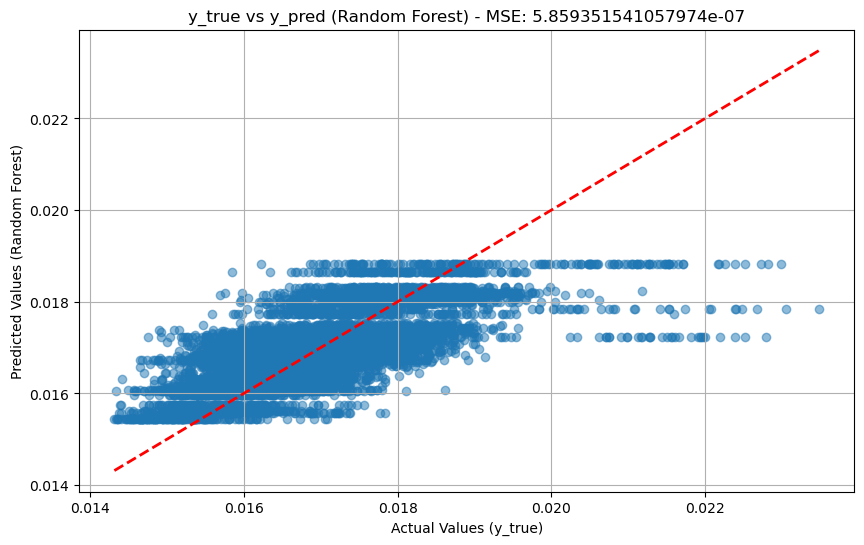

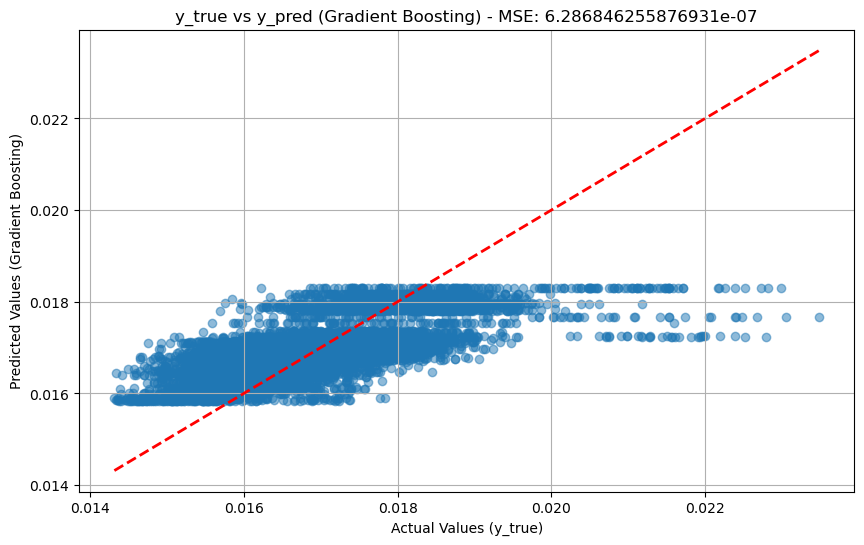

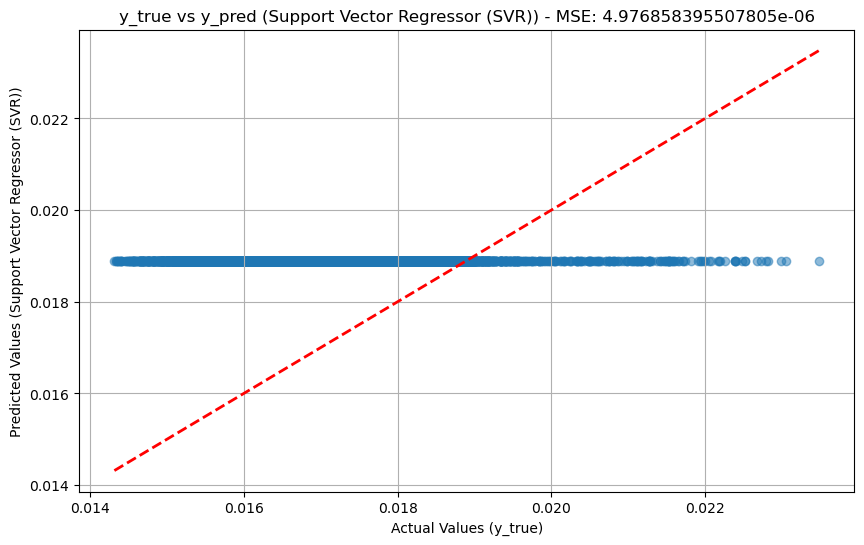

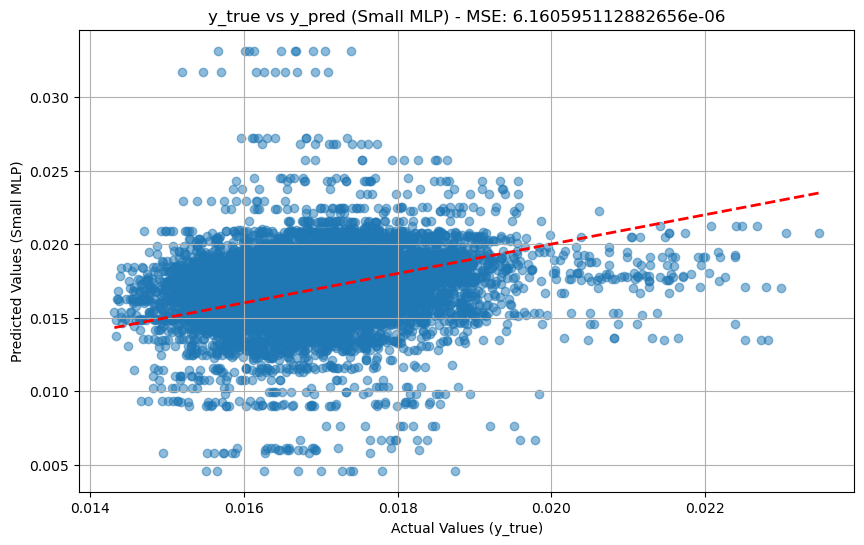

Random Forest - Result: 5.859351541057974e-07
Gradient Boosting - Result: 6.286846255876931e-07
Support Vector Regressor (SVR) - Result: 4.976858395507805e-06
Small MLP - Result: 6.160595112882656e-06


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Extract features and target
X = get_binary_features(df_not_grouped)
y = df_not_grouped["test_loss"]

# Split data into train/test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models with optimal parameters for binary features and small regression targets
models = {
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=20, max_depth=5),
    "Small MLP": MLPRegressor(hidden_layer_sizes=(16, 16), activation="relu", solver="adam", learning_rate_init=0.01, max_iter=3000, random_state=42, alpha=0)
}

# Fit models, evaluate, and save plots
results = {}

for model_name, model in models.items():
    # Fit model
    model.fit(X, y)
    # Predict on test data
    y_pred = model.predict(X)
    # Calculate MSE
    mse = mean_squared_error(y, y_pred)
    results[model_name] = mse

    # Save plot of y_true vs y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Perfect prediction line
    plt.xlabel("Actual Values (y_true)")
    plt.ylabel(f"Predicted Values ({model_name})")
    plt.title(f"y_true vs y_pred ({model_name}) - MSE: {mse}")
    plt.grid(True)
    plt.show()
    
# Print MSE for all models
for model_name, result in results.items():
    print(f"{model_name} - Result: {result}")


In [ ]:
X_train = X
X_test = X
y_train = y
y_test = y

In [ ]:
## Random Forest - Hyperparameter Tuning
#from sklearn.model_selection import GridSearchCV

#param_grid_rf = {
#    "n_estimators": [10, 20],
#    "criterion":["squared_error", "absolute_error"],
#    "max_depth": [3, 5, 10, None],
#    "min_samples_split": [2, 5],
#    "min_samples_leaf": [1, 2, 5]
#}

#grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring="neg_mean_squared_error")
#grid_search_rf.fit(X_train, y_train)

#best_rf = grid_search_rf.best_estimator_
#print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
#y_pred_rf = best_rf.predict(X_test)
#mse_rf = mean_squared_error(y_test, y_pred_rf)
#print("Random Forest - Improved MSE:", mse_rf)


In [ ]:
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import mean_squared_error

## Define parameter grid
#param_grid_gb = {
#    "loss":["squarred_error", "absolute_error"],
#    "n_estimators": [10, 20],
#    "learning_rate": [0.001, 0.01, 0.1],
#    "max_depth": [3, 5, 7],
#    "subsample": [0.8, 1.0]
#}

## Perform grid search
#grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring="neg_mean_squared_error")
#grid_search_gb.fit(X_train, y_train)

## Best model and evaluation
#best_gb = grid_search_gb.best_estimator_
#print("Gradient Boosting - Best Parameters:", grid_search_gb.best_params_)
#y_pred_gb = best_gb.predict(X_test)
#mse_gb = mean_squared_error(y_test, y_pred_gb)
#print("Gradient Boosting - Improved MSE:", mse_gb)


In [ ]:
# Function to plot the best model's predictions
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

def plot_best_model(y_test, y_pred, model_name, mse):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.xlabel("Actual Values (y_true)")
    plt.ylabel("Predicted Values (y_pred)")
    plt.title(f"{model_name} - Best Model Predictions\nMSE: {mse}")
    plt.grid(True)
    plt.show()

MLP - Best Parameters: {'alpha': 0, 'batch_size': 8, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.0001, 'max_iter': 2000}
MLP - Improved MSE: 1.1524031174533991e-06


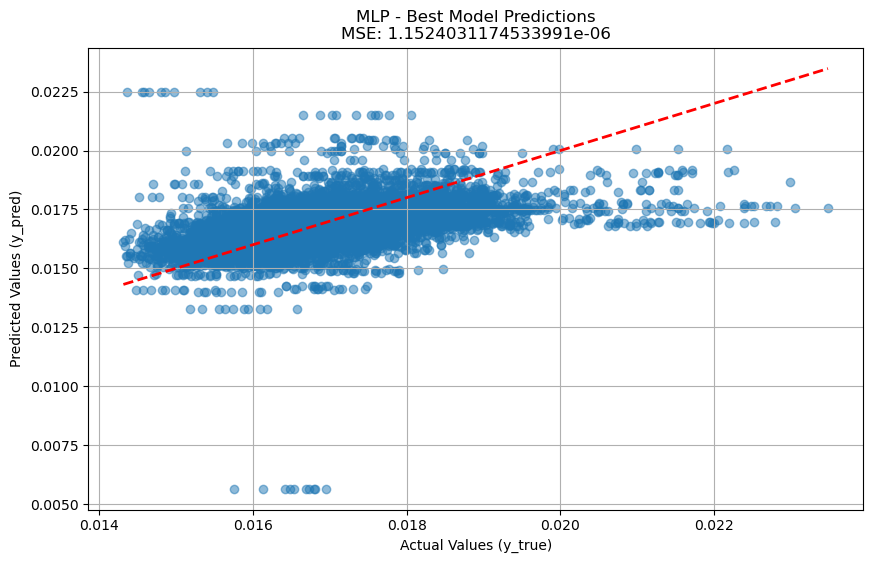

In [ ]:
# Small MLP - Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid_mlp = {
    "hidden_layer_sizes": [(10)],
    "learning_rate_init": [0.0001],
    "batch_size": [8],
    "alpha": [0],
    "max_iter": [3000]
}

grid_search_mlp = GridSearchCV(MLPRegressor(activation="relu", solver="adam", random_state=42), param_grid_mlp, cv=5, scoring="neg_mean_squared_error")
grid_search_mlp.fit(X_train, y_train)

best_mlp = grid_search_mlp.best_estimator_
print("MLP - Best Parameters:", grid_search_mlp.best_params_)
y_pred_mlp = best_mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print("MLP - Improved MSE:", mse_mlp)

plot_best_model(y_test, y_pred_mlp, "MLP", mse_mlp)


# Kinda old!

In [ ]:
# fill dataframe with group means and stds



group_list = []

for group, df in results_out.groupby(["features"]):
    print(group)
    print(df["model_losses"].mean())
    print(df["model_losses"].std())
    print()
    # add data to new dataframe
    
    group_list.append(
        (group[0], df["model_losses"].mean(), df["model_losses"].std())
    )
    
df_plot = pd.DataFrame(group_list, columns=["features", "mean", "std"])



('occrate',)
0.020438333333333336
0.0002250896117845821

('occrate_avgocc',)
0.018653666666666666
0.0003666365139117126

('occrate_avgocc_coursenumber',)
0.016270666666666666
0.00020652441340755182

('occrate_coursenumber',)
0.016612666666666668
0.0004147051161166604



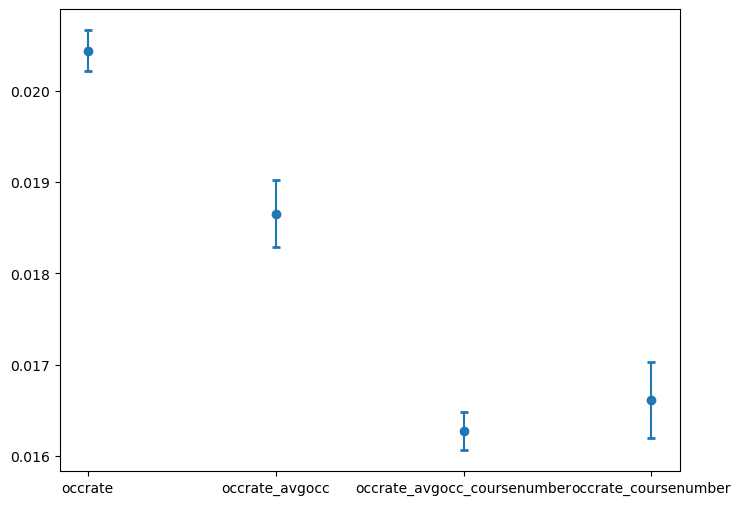

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot mean with error bars (standard deviation)
ax.errorbar(
    df_plot["features"],
    df_plot["mean"],
    yerr=df_plot["std"],
    fmt="o",
    capsize=3,
    capthick=2,
    label="Mean MAE with Std Dev",
)

plt.show()

In [ ]:
def advanced_grouping_function(features):
    if "coursenumber" in features:
        return "yes"
    else:
        return "no"
    
    

In [ ]:
def advanced_grouping_function(features):
    if "coursenumber" in features:
        return "yes"
    else:
        return "no"
group_by_avgocc = results_out.groupby(results_out["features"].apply(advanced_grouping_function))
group_by_avgocc["model_losses"].mean()


features
no     0.019546
yes    0.016442
Name: model_losses, dtype: float64

In [ ]:
def advanced_grouping_function(features):
    if "avgocc" in features:
        return "yes"
    else:
        return "no"
    
group_by_avgocc = results_out.groupby(results_out["features"].apply(advanced_grouping_function))
group_by_avgocc["model_losses"].mean()

features
no     0.018526
yes    0.017462
Name: model_losses, dtype: float64

In [ ]:
pretty_results = results_out[["features", "model_losses", "avg_baselines", "naive_baselines", "zero_baselines"]]

# split features by "_"
pretty_results["features"] = pretty_results["features"].apply(lambda x: x.split("_"))

# do not cut off columns
pd.set_option('display.max_colwidth', None)
pretty_results.reset_index(drop=True, inplace=True)



In [ ]:
#pretty_results.to_csv("pretty_results.csv", index=False)